In [1]:
# analyze raw pose estimation from vertical videos only and get gait metrics

# required folder structure of input folder (raw_pose_data_in_path, mirrors video folder structure)
# raw_pose_data_in_path
    # participant 1
        # date 
            # 000_raw_pose_data (folder containing pose, world, and yolo raw pose data .csv files) 
    # BW-12 
        # 2024-05-02  
            # 000_raw_pose_data (folder containing pose, world, and yolo raw pose data .csv files)

#  outputs from this analysis per patient will be saved in the same folder 

#raw_pose_data_in_path
    # participant 1
        # date 
            # 001 analysis results 
            # 002 analysis results 

# .csv for all participants in raw_pose_data_in_path saved as all_participants_pose_metrics_df variable 
    # save pose metrics from all videos in raw_pose_data_in_path saved as  
    # 'all_participants_pose_metrics_df.csv' in raw_pose_data_in_path folder 

# note! if more than three videos for each task, need to update 'task' variable below to include 'gait_vertical_left_3' etc 

# try for no spaces in folder and file names, but should still work if there are spaces 

In [2]:
# import libraries 
import pandas as pd 
import numpy as np 
import os 
import re

In [3]:
# import functions from sandbox src code files 
from raw_pose_analysis_funs.merge_mp_yolo_dfs import (merge_mp_pose_world, clean_mp_yolo_missing_data, add_orientation_and_turn_direction, save_merge_mp_yolo_df)
from raw_pose_analysis_funs.frames_to_time import (add_time_column, save_df_w_time)
from raw_pose_analysis_funs.landmark_visibility import (mp_vis_all_labels_boxplot, mp_vis_lineplot, mp_save_vis_stats_by_label, yolo_vis_lineplot)
from raw_pose_analysis_funs.select_linear_walking import select_plot_linear_walking
from raw_pose_analysis_funs.segment_video_walk_turn import (segment_video_interp_filter, segment_video_walks_turn)
from raw_pose_analysis_funs.gait_metric_stride_time import(stride_time_interp, calculate_stride_time)
from raw_pose_analysis_funs.gait_metric_cadence import (calculate_cadence)
from raw_pose_analysis_funs.gait_metric_stride_width import (stride_width_interp, calculate_stride_width)
from raw_pose_analysis_funs.gait_metric_support import (support_interp, ankle_y_vel_accel_peak_min, id_toe_off_heel_strike, calculate_single_double_support)
from raw_pose_analysis_funs.gait_metrics_compile_stats import save_all_pose_metrics

In [4]:
# set variables manually  

# Set input path to run all analysis 
# folder with all raw pose data (dir_in_path) 
raw_pose_data_in_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_hc_outputs\NW_HC'

# input variables for interpolation and filtering 
max_gap = 0.12 # max gap to interpolate over 
cutoff = 0.4
order = 1

In [5]:
# save list of all csv files in raw pose data folders 

raw_data_full_path_all = [] 
raw_data_file_names_all = []

# loop through all files in input path 
for (dir_path, dir_names, file_names) in os.walk(raw_pose_data_in_path):
    for file_name in file_names: 
        name, ext = os.path.splitext(file_name)
        ext = ext.lower()[1:]
        current_raw_data_in_path = os.path.join(dir_path, file_name) # full path to files 
        # save full path to file if it meets requirements to be raw pose data 
        if (ext == 'csv') & ('000_raw_pose_data' in current_raw_data_in_path): # from run.py, outputs all saved in 000_raw_pose_data_folder
            raw_data_full_path_all = raw_data_full_path_all + [current_raw_data_in_path]
            raw_data_file_names_all = raw_data_file_names_all + [file_names]

In [6]:
# find all unique ID date combos (each unique folder with videos)

id_date_all = []
for file_i, raw_path in enumerate(raw_data_full_path_all): 
    parent_path_1, current_file_name = os.path.split(raw_path)
    parent_path_2, current_raw_data_folder = os.path.split(parent_path_1)
    parent_path_3, current_date = os.path.split(parent_path_2)
    parent_path_4, current_id = os.path.split(parent_path_3)
    current_id_date = os.path.join(current_id, current_date)
    id_date_all = id_date_all + [current_id_date]

# add if statement to pick specific IDs
#if float(current_id[3:]) >= 288:
       # current_id_date = os.path.join(current_id, current_date)
      #  id_date_all = id_date_all + [current_id_date]

In [7]:
# create blank data frame to populate in for loop below 
all_participants_pose_metrics_df = pd.DataFrame(
    columns = ['id_date_pose',
               'video_id_date_name_pose', 
               'task_pose',
               'turn_time_mean_sec_pose',
               'turn_time_median_sec_pose',
               'turn_time_sd_pose', 
               'turn_time_cv_pose',
               'cadence_pose',
               'stride_time_leg_1_peaks_mean_sec_pose',
               'stride_time_leg_1_peaks_median_sec_pose',
               'stride_time_leg_1_peaks_std_pose', 
               'stride_time_leg_1_peaks_cv_pose',
               'stride_time_leg_2_valleys_mean_sec_pose',
               'stride_time_leg_2_valleys_median_sec_pose',
               'stride_time_leg_2_valleys_std_pose',
               'stride_time_leg_2_valleys_cv_pose',
               'stride_time_all_strides_mean_sec_pose',
               'stride_time_all_strides_median_sec_pose',
               'stride_time_all_strides_std_pose',
               'stride_time_all_strides_cv_pose',
               'stride_width_mean_m_pose', 
               'stride_width_median_m_pose',
               'stride_width_std_pose',
               'stride_width_cv_pose',
               'right_gait_cycle_time_pose',
               'right_stance_time_pose',
               'right_stance_per_pose', 
               'right_swing_time_pose',
               'right_swing_per_pose', 
               'right_ini_double_support_time_pose',
               'right_term_double_support_time_pose',
               'right_tot_double_support_time_pose',
               'right_double_support_per_pose',
               'right_single_support_time_pose', 
               'right_single_support_per_pose',
               'left_gait_cycle_time_pose', 
               'left_stance_time_pose',
               'left_stance_per_pose', 
               'left_swing_time_pose', 
               'left_swing_per_pose',
               'left_ini_double_support_time_pose',
               'left_term_double_support_time_pose',
               'left_tot_double_support_time_pose',
               'left_double_support_per_pose',
               'left_single_support_time_pose', 
               'left_single_support_per_pose'])

all_participants_pose_metrics_df = all_participants_pose_metrics_df.dropna(how='all', axis=1)

Analyzing data from: NW_HC\2024-05-02
dir_out_prefix: C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_hc_outputs\NW_HC\2024-05-02
video_id_date_name: gait_vertical_left_NW_HC_2024-05-02
include: valid segments exist
0
<class 'pandas.core.frame.DataFrame'>
[0.8373521886187602]
----
1
<class 'pandas.core.frame.DataFrame'>
[0.8373521886187602, 0.8464483781512003]
----
2
<class 'pandas.core.frame.DataFrame'>
[0.8373521886187602, 0.8464483781512003, 0.8470707562960447]
----
greater than 0.75


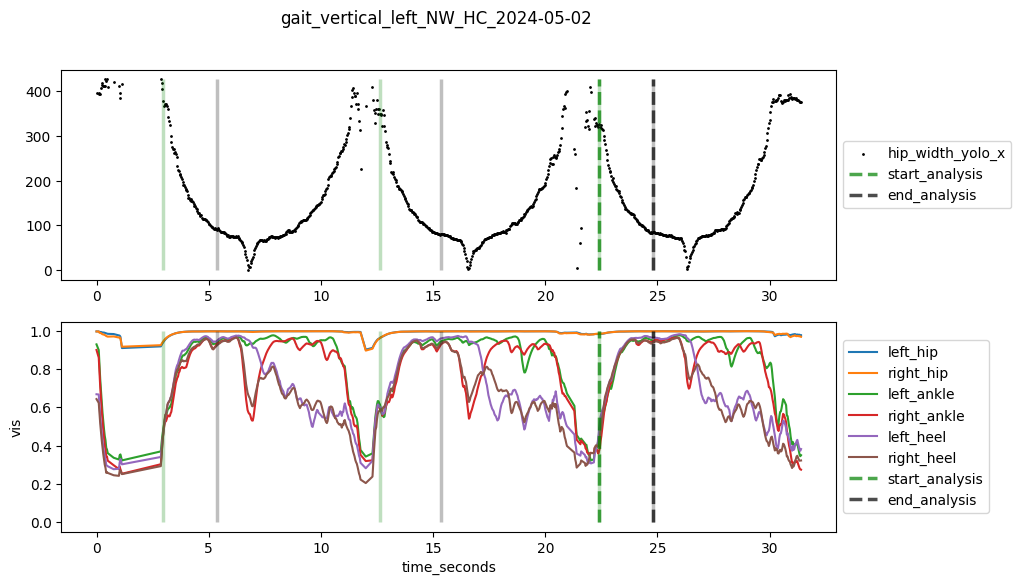

Skipped: no files matching gait_vertical_left_2
Skipped: no files matching gait_vertical_left_3
video_id_date_name: gait_vertical_right_NW_HC_2024-05-02
include: valid segments exist
0
<class 'pandas.core.frame.DataFrame'>
[0.8699615871906281]
----
1
<class 'pandas.core.frame.DataFrame'>
[0.8699615871906281, 0.8352586249292115]
----
2
<class 'pandas.core.frame.DataFrame'>
[0.8699615871906281, 0.8352586249292115, 0.8378067699762491]
----
greater than 0.75


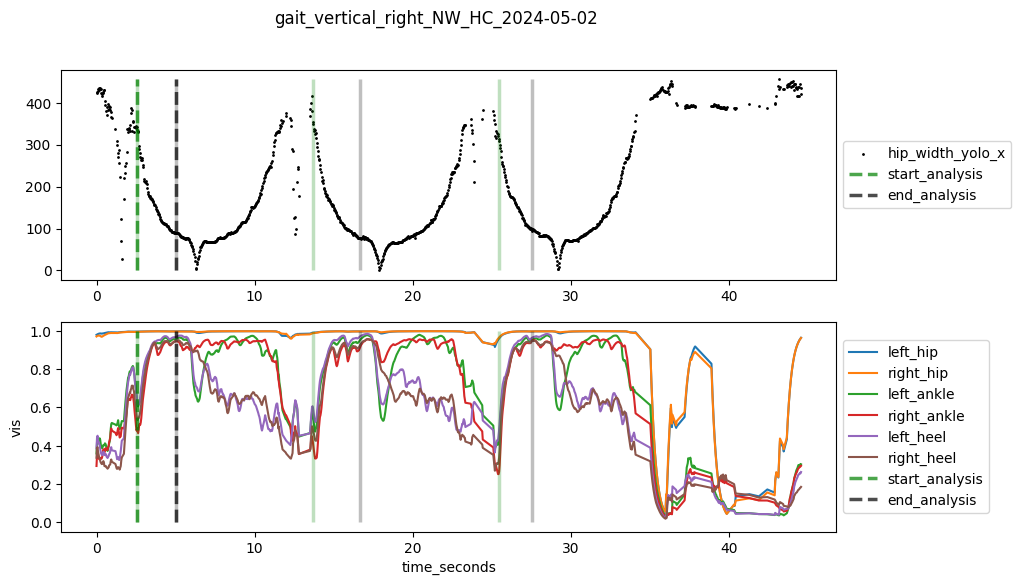

Skipped: no files matching gait_vertical_right_2
Skipped: no files matching gait_vertical_right_3
Skipped: no files matching gait_vertical_PWS_1
Skipped: no files matching gait_vertical_PWS_2
Skipped: no files matching gait_vertical_FW_1
Skipped: no files matching gait_vertical_FW_2
Skipped: no files matching gait_vertical_TUG_1
Skipped: no files matching gait_vertical_TUG_2


In [20]:
# for each unique ID and date combo, 
#select either all gait_vertical_right .csv files or all gait_vertical_left files and run all analysis 

# all unique ID and date combos of .csv files in raw pose data folder 
unique_id_date = list(set(id_date_all))
unique_id_date = sorted(unique_id_date) # run in same order every time

# gait_vertical_left and gait_vertical_right = home videos 
# PWS, FW, and TUG = in person BW zeno videos 
tasks = ['gait_vertical_left', 
         'gait_vertical_left_2', 
         'gait_vertical_left_3',
         'gait_vertical_right', 
         'gait_vertical_right_2',
         'gait_vertical_right_3',
         'gait_vertical_PWS_1',
         'gait_vertical_PWS_2',
         'gait_vertical_FW_1', 
         'gait_vertical_FW_2',
         'gait_vertical_TUG_1',
         'gait_vertical_TUG_2'
        ] 

# set blank variables to add file names to be included or excluded 
included_videos = []
excluded_videos = []

for id_date_i, id_date in enumerate(unique_id_date): 
    print('Analyzing data from: ' + id_date)
    # select raw data paths that match id_date combo 
    current_id_date_csv_file_paths = [item for item in raw_data_full_path_all if id_date in item]
    
    # set output folder prefix. Find relative paths relative from input folder to raw data .csv 
    raw_data_relpath = os.path.relpath(current_id_date_csv_file_paths[1], raw_pose_data_in_path)
    rel_path_to_date_subfolder, raw_data_subfolder = os.path.split(os.path.dirname(raw_data_relpath))
    dir_out_prefix = os.path.normpath(os.path.join(raw_pose_data_in_path, rel_path_to_date_subfolder))
    print('dir_out_prefix: ' + dir_out_prefix)
    
    # select raw data paths that match right or left vertical task/video
    for task_i, task, in enumerate(tasks):  
        # select files matching current task 
        current_task_csv_paths = [item for item in current_id_date_csv_file_paths if task in item]
        
        # if files with raw data for this task is saved in subfolder, run analysis  
        if len(current_task_csv_paths) == 0: 
            print('Skipped: no files matching ' + task)
        elif len(current_task_csv_paths) > 0:   
  
            # after selecting for correct task, save each raw data path as own variable 
            current_yolo_data_path = [item for item in current_task_csv_paths if 'yolo.csv' in item]
            current_mp_pose_data_path = [item for item in current_task_csv_paths if 'mediapipe.csv' in item]
            current_mp_world_data_path = [item for item in current_task_csv_paths if 'mediapipe_world.csv' in item]
            current_video_fps_path = [item for item in current_task_csv_paths if 'fps.csv' in item]

            # # [-1]: if more than 1 'gait_vertical_right' video, 
                # make sure to select 'gait_vertical_right' (last path), not 'gait_vertical_right_2' 
            if len(current_yolo_data_path) > 1: 
                current_yolo_data_path = [sorted(current_yolo_data_path)[-1]]
            if len(current_mp_pose_data_path) > 1:
                current_mp_pose_data_path = [sorted(current_mp_pose_data_path)[-1]]
            if len(current_mp_world_data_path) > 1:
                current_mp_world_data_path = [sorted(current_mp_world_data_path)[-1]]
            if len(current_video_fps_path) > 1:
                current_video_fps_path = [sorted(current_video_fps_path)[-1]]
            
            # read in raw pose data, all three types 
            mp_pose_df = pd.read_csv(current_mp_pose_data_path[0])
            mp_world_df = pd.read_csv(current_mp_world_data_path[0])
            yolo_df = pd.read_csv(current_yolo_data_path[0])
            
            # read in frames per seconds and save as var for future code 
            fps_df = pd.read_csv(current_video_fps_path[0], index_col = 0)
            fps = fps_df.iloc[0,0]

            # set video ID - ID_date_task (analogous to vid_in_path in run script, use for plot and file names)
            yolo_basename = os.path.splitext(os.path.basename(current_yolo_data_path[0]))[0]
            video_id_date_name = (yolo_basename).replace('yolo', id_date).replace('\\', '_')
            print('video_id_date_name: ' + video_id_date_name)
        
            # run analysis functions 
            # step 001 - save updated .csv files in 001 output folder 
            [mp_all_df, yolo_df] = merge_mp_pose_world(mp_pose_df, mp_world_df, yolo_df)
            [mp_all_df, yolo_df] = clean_mp_yolo_missing_data(mp_all_df, yolo_df)
            [mp_all_df, yolo_df] = add_orientation_and_turn_direction(video_id_date_name, mp_all_df, yolo_df) # check vid_in_path 
            save_merge_mp_yolo_df(mp_all_df, yolo_df, video_id_date_name, dir_out_prefix)

            # 002 frames to time: save .csv file with seconds in 003 output folder 
            [mp_all_df, yolo_df] = add_time_column(mp_all_df, yolo_df, fps)
            save_df_w_time(mp_all_df, yolo_df, video_id_date_name, dir_out_prefix)

            # 003 - plot and save landmark visibility scores for yolo and mediapipe 
            # yolo 
            yolo_vis_lineplot(yolo_df, video_id_date_name, dir_out_prefix)
            # mediapipe 
            mp_vis_all_labels_boxplot(mp_all_df, video_id_date_name, dir_out_prefix) 
            mp_vis_lineplot(mp_all_df, video_id_date_name, dir_out_prefix)
            # calculate and save mean, standard deviation, and median visibility for each marker
            vis_stats_df = mp_save_vis_stats_by_label(mp_all_df, video_id_date_name, dir_out_prefix)

            # -------------------------------------
            # 3.5 test selecting linear walking, remove extraneous activity 
            valid_segment_found, start_sec, end_sec, walk_segment_mp_all_df, walk_segment_yolo_df = select_plot_linear_walking(mp_all_df, 
                                                                                                                               yolo_df, 
                                                                                                                               video_id_date_name, 
                                                                                                                               dir_out_prefix)
            # if not valid segments found, skip analysis steps and save name to exclude list 
            if valid_segment_found == 0: 
                excluded_videos.append(video_id_date_name) 
            else: 
                included_videos.append(video_id_date_name)
            
            # ----------------------------------------

            # 004 - segment walking toward camera, away from camera, or turning based on hip positions
            # interpolate and filter mp hip Z position, L and R 
            # interpolate yolo hip X position, L and R 
           
            #[mp_hip_z_filt, yolo_hip_x_interp] = segment_video_interp_filter(mp_all_df,
                                                                           #  yolo_df, 
                                                                            # video_id_date_name, 
                                                                           #  dir_out_prefix, 
                                                                           #  max_gap, 
                                                                           #  fps, 
                                                                           #  cutoff, 
                                                                           #  order)
            
            # using interpolated and filtered data, ID toward, away, or turn
            # save plots and .csv files 
            
          #  [turn_df, walks_df] = segment_video_walks_turn(mp_hip_z_filt, yolo_hip_x_interp, video_id_date_name, dir_out_prefix, fps,
                                                       #    find_peaks_distance = 3 * fps, # min distance between hip z distance peaks (frames) 
                                                        #   find_peaks_prominence = 0.2, # hip Z peaks need to be greater than this value to count as a turn
                                                         #  flattening_point_atol = 0.01, # Distance of hip z diff away from zero to be identified as "flattening point"
                                                         #  dist_turn_mid_to_flattening = 20, # flattening point has to be at least this many frames from turn midpoint
                                                          # mean_rolling_window_size = 20)  # smooth curve over this many frames 

            #005 calculate gait metrics 
            # stride time 
            
          #  mp_ankle_Y_interp = stride_time_interp(mp_all_df,video_id_date_name, dir_out_prefix, max_gap, fps)
          #  [stride_time_stats_df, stride_times_peaks, stride_times_valleys] = calculate_stride_time(mp_ankle_Y_interp, fps,
                                                                                               #      video_id_date_name, dir_out_prefix,
                                                                                                  #   rolling_mean_window = round(.5 * fps), 
                                                                                                   #  find_peaks_distance = round(.33 * fps), # min distance between ankle y distance peaks (frames) 
                                                                                                   #  find_peaks_prominence = 0.01) # ankle y peaks need to be greater than this value to count as step

            # cadence 
            
          #  [total_steps, video_length_sec, cadence_df] = calculate_cadence(stride_times_peaks, stride_times_valleys,
                                                                     #    fps, mp_all_df, 
                                                                       #  video_id_date_name, dir_out_prefix)

            # stride width 
            
          #  mp_stride_width_interp_dfs = stride_width_interp(mp_all_df, video_id_date_name, dir_out_prefix, max_gap, fps)
           # stride_width_stats_df = calculate_stride_width(mp_stride_width_interp_dfs, video_id_date_name, dir_out_prefix)

            # double and single support
            # select and interpolate ankle y data 
            
          #  yolo_support_interp_dfs = support_interp(yolo_df, video_id_date_name, dir_out_prefix, max_gap, fps)
          #  right_ankle_y = yolo_support_interp_dfs[0]
         #   left_ankle_y = yolo_support_interp_dfs[1]

            # find peaks and min of velocity and acceleration 
          #  right_ank_y_data = ankle_y_vel_accel_peak_min(right_ankle_y, 
                                                      #    diff_period = round(.167 * fps),  # frames to take diff between for vel + accel
                                                      #    peaks_distance = round(.167 * fps), # min distance between peaks + valleys 
                                                      #    peaks_prominence_percent_max = .05, # percent of biggest peak that each peak must be greater than to be identified 
                                                      #    valleys_prominence_percent_max = .10) # percent of biggest peak that each valley must be greater than to be identified 
         #   left_ank_y_data = ankle_y_vel_accel_peak_min(left_ankle_y, 
                                                   #      diff_period = round(.167 * fps),  # frames to take diff between for vel + accel
                                                    #     peaks_distance = round(.167 * fps), # min distance between peaks + valleys 
                                                    #     peaks_prominence_percent_max = .05, 
                                                    #     valleys_prominence_percent_max = .10)

            # get gait events from position, velocity, and acceleration data
        #    toe_off_heel_strike_df = id_toe_off_heel_strike(right_ank_y_data, left_ank_y_data, video_id_date_name, dir_out_prefix)

            # calculate single and double support from toe off and heel strike frames 
         #   support_metrics_df = calculate_single_double_support(toe_off_heel_strike_df, fps, video_id_date_name, dir_out_prefix)

            # compile all metrics stats for one participant into one .csv and save 
          #  pose_metrics_df = save_all_pose_metrics(id_date, video_id_date_name, task, turn_df, cadence_df,
                                                #     stride_time_stats_df, stride_width_stats_df, 
                                                 #    support_metrics_df, dir_out_prefix)

            # add this participant to all participants df 
         #   all_participants_pose_metrics_df = pd.concat([all_participants_pose_metrics_df, 
                                                       #    pose_metrics_df], 
                                                       #   axis = 0)

raw_parent, all_gait_metrics_filename = os.path.split(raw_pose_data_in_path)
# all_participants_pose_metrics_df.to_csv(os.path.join(raw_pose_data_in_path, (all_gait_metrics_filename + '_pose_metrics_all.csv')))
# print("Saving pose_metrics_all.csv")

# save file on included vs excluded walks 
excluded_videos_df = pd.DataFrame(data = {'excluded_vids' : excluded_videos})
excluded_videos_df.to_csv(os.path.join(raw_pose_data_in_path, (all_gait_metrics_filename + '_excluded_videos.csv')))

included_videos_df = pd.DataFrame(data = {'included_vids' : included_videos})
included_videos_df.to_csv(os.path.join(raw_pose_data_in_path, (all_gait_metrics_filename + '_included_videos.csv')))

In [19]:
## test new code 
excluded_videos_df = pd.DataFrame(data = {'excluded_vids' : excluded_videos})

included_videos_df = pd.DataFrame(data = {'included_vids' : included_videos})
included_videos_df

,included_vids
0,gait_vertical_left_NW_HC_2024-05-02
1,gait_vertical_right_NW_HC_2024-05-02
